# Import Library

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Initial Setup

In [84]:
n_points = 100
interval = [-100, 100]
n_partition = 10
partition_max_n = 12
partition_min_n = 8

## Generate Random Points

In [75]:
def generate_rand_points(n, interval): 
    return np.random.rand(2, n) * interval[0] + interval[1]

In [76]:
rand_points = generate_rand_points(n_points, interval)

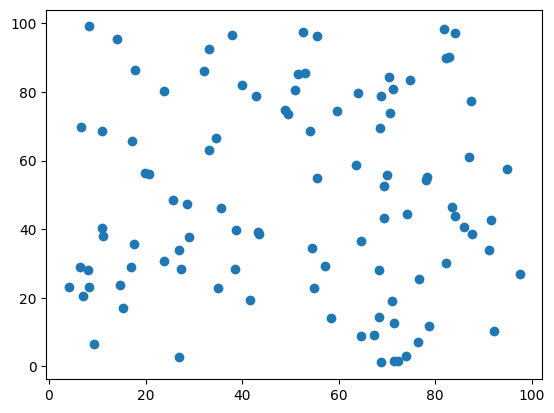

In [77]:
plt.scatter(rand_points[0], rand_points[1])

## Calculate Weight

In [78]:
def calculate_weight(points):
    weight = np.zeros([n_points, n_points])
    size = points.shape
    for i in range(size[1]):
        for j in range(size[1]):
            if i != j: 
                weight[i, j] = np.sqrt(np.abs(points[0][i] - points[0][j]) + np.abs(points[1][i] - points[1][j]))
    return weight

In [79]:
weight = calculate_weight(rand_points)

## Set Partition

In [193]:
class Partition: 
    def __init__(self): 
        self.points_x = np.array([])
        self.points_y = np.array([])

    def get_points(self):
        return self.points_x[0], self.points_y[0]

    def spread(self):
        return max(max(self.points_x) - min(self.points_y), max(self.points_y) - min(self.points_y))

    def add_point(self, new_x, new_y): 
        self.points_x = np.append(self.points_x, new_x),
        self.points_y = np.append(self.points_y, new_y),

    def remove_point(self, index):
        self.points_x = np.delete(index, self.points_x)
        self.points_y = np.delete(index, self.points_y)

    def get_weight(self):
        size = len(self.points_x[0])
        temp = np.zeros([size, size])
        for i in range(size):
            for j in range(size):
                if i != j: 
                    temp[i, j] = np.sqrt(np.abs(self.points_x[0][i] - self.points_x[0][j]) + np.abs(self.points_y[0][i] - self.points_y[0][j]))
        return temp

In [194]:
partitions = np.array([])

for i in range(n_partition):
    partitions = np.append(partitions, Partition())